In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from file_manager import FileManager
fm = FileManager()

In [2]:
# Pass in player dataframe
def overview(df: pd.DataFrame):
    infocols: list[str,...] = ['date', 'name', 'team', 'opp', 'starter']
    statcols: list[str,...] = [col for col in df.columns if col not in infocols]

    last10: list[str,...] = list((df
                                  .sort_values('date', ascending=False)
                                  ['date']
                                 ))[:10]
    
    last5: list[str,...] = last10[:5]
    
    # overview
    ov: dict[str,str|int|float] = {
        'name': df['name'].drop_duplicates().item(),
        'team(s)': ','.join(df['team'].drop_duplicates()),
        'played': len(df),
        'started': len(df.loc[df['starter']==1])
    }
    
    distro: pd.Series = df['fpts'].describe().round(1)
    
    ov: dict[str, str|int|float] = {
        **ov,
        **{'ceiling': distro['75%'],'floor': distro['25%']},
        **{f'med-{stat}': np.median(df[stat]).round(2) for stat in statcols},
        **{
            f'l10-median-{stat}': np.median(df.loc[df['date'].isin(last10),stat]) 
            for stat in ('fpts', 'fppm', 'mp')
        },
        **{
            f'l5-median-{stat}': np.median(df.loc[df['date'].isin(last5),stat]) 
            for stat in ('fpts', 'fppm', 'mp')
        }
    }
    
    return pd.Series(ov)

In [3]:
# Return graph of player outcomes
def view_player(name: str, **kwargs):
    
    columns: list[str,...] = [
        'date',
        'name',
        'team',
        'opp',
        'fpts',
        'mp',
        'fppm',
        'usg',
        'pts',
        'ast',
        'trb',
        'starter'
    ]
    
    stats: list[str,...] = sum([
        columns,
        kwargs.get('stats', [])
    ], [])
    
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
    
    df: pd.DataFrame = (fm
                        .load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'] == name)
                                                  & df_['starter'].isin(starter_)
                                                 ])
                        [stats]
                       )
    
    
    ov: pd.Series = overview(df)
    bins_: int = int(ov['played']) // 1
    print(ov)
    
    plot: str = kwargs.get('plot', 'histogram')
    plotkwargs = {kw:arg for kw,arg in kwargs.items() if kw not in ('stats','target', 'starter')}
    
    plotkwargs = {
        **plotkwargs,
        **{'figsize': plotkwargs.get('figsize',(15,10)), 'bins': plotkwargs.get('bins', bins_)}
    }
    
    target: str = kwargs.get('target', 'fpts')
    
    
    if plot in ('hist', 'histogram'):
        return (df
                .plot
                .hist(
                    column=[target],
                    # Nondefault args for hist
                    # bins=plotkwargs.get('bins', 7),
                    # figsize=figsize,
                    **plotkwargs
                )
               )
    
    if plot in ('box', 'boxplot'):
        return (df
                .plot
                .box(column=[target],figsize=plotkwargs['figsize'])
               )
    
    return None

name               Kelly Oubre
team(s)                    CHA
played                      30
started                     30
ceiling                   40.6
floor                     27.0
med-fpts                  35.9
med-mp                   34.09
med-fppm                  1.02
med-usg                   0.26
med-pts                   20.0
med-ast                    1.0
med-trb                    5.0
l10-median-fpts           38.9
l10-median-fppm       1.076448
l10-median-mp           38.175
l5-median-fpts            41.1
l5-median-fppm        1.113318
l5-median-mp         37.133333
dtype: object


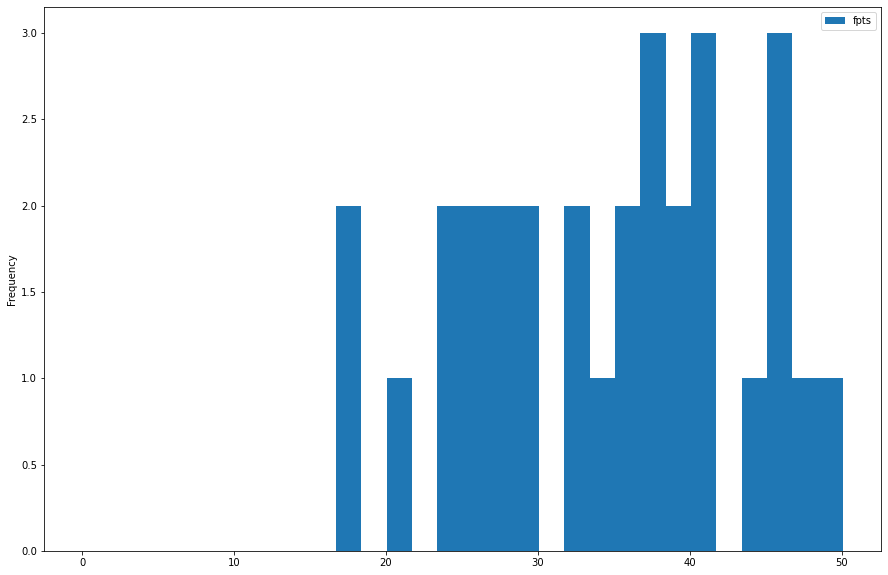

In [4]:
view_player(
    'Kelly Oubre',
    starter=True,
    # plot='box',
    # bins=46,
);

In [27]:
boom_bust('James Harden', 10100, starter=True)

boom    13.64
bust    61.36
dtype: float64